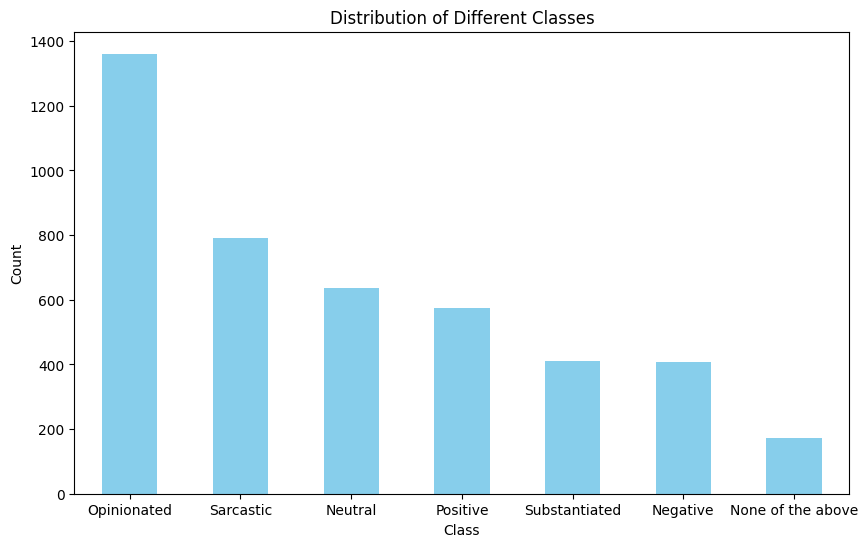

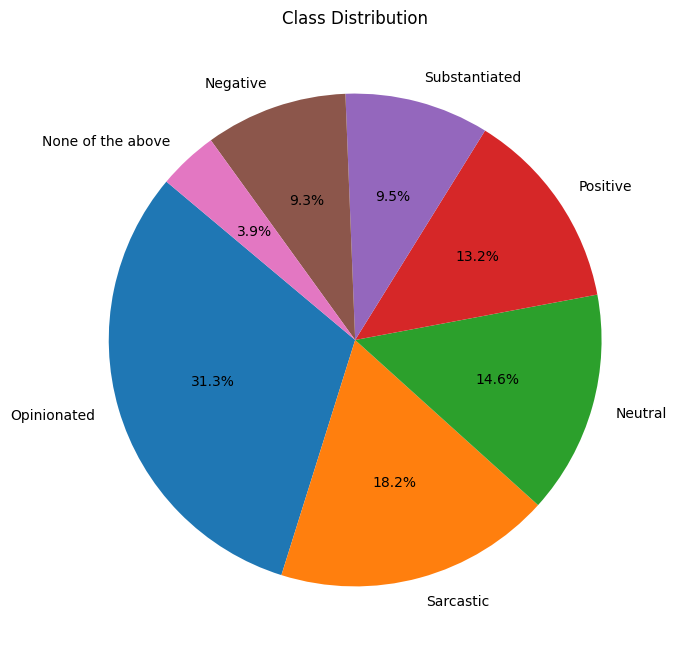

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../Data/PS_train.csv')

class_counts = data['labels'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Different Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 8))
class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()


In [60]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your dataset
df = pd.read_csv('preprocessed_data.csv')

# Example structure of content dict
df['content'] = df['content'].apply(eval)


In [61]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['labels'])


In [62]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Custom Dataset class
class TamilTweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['content'].apply(lambda x: x['tamil_sentences']), df['labels'], test_size=0.2, random_state=42)

# Create data loaders
train_dataset = TamilTweetDataset(train_texts.tolist(), train_labels.tolist())
test_dataset = TamilTweetDataset(test_texts.tolist(), test_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [63]:
# Load BERT model
model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

# Function to extract embeddings
def extract_embeddings(model, data_loader, device):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Average the token embeddings
            all_embeddings.extend(embeddings.cpu().numpy())

    return torch.tensor(all_embeddings)

# Extract embeddings for train and test sets
train_embeddings = extract_embeddings(model, train_loader, device)
test_embeddings = extract_embeddings(model, test_loader, device)

# Save embeddings as tensors
torch.save(train_embeddings, 'train_embeddings.pt')
torch.save(test_embeddings, 'test_embeddings.pt')

# Save the corresponding labels as tensors
torch.save(torch.tensor(train_labels.to_numpy()), 'train_labels.pt')
torch.save(torch.tensor(test_labels.to_numpy()), 'test_labels.pt')


In [3]:
import pandas as pd
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
# Load embeddings and labels
train_embeddings = torch.load('train_embeddings.pt').numpy()
train_labels = torch.load('train_labels.pt').numpy()

# Ensure label encoder is available
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

LabelEncoder()

In [5]:
# Use t-SNE to reduce dimensions to 3D for visualization
tsne = TSNE(n_components=3, random_state=42)
train_embeddings_3d = tsne.fit_transform(train_embeddings)

# Create a DataFrame for visualization
df_viz = pd.DataFrame({
    'x': train_embeddings_3d[:, 0],
    'y': train_embeddings_3d[:, 1],
    'z': train_embeddings_3d[:, 2],
    'label': train_labels
})

# 3D Plot with Plotly for interactive visualization
fig = px.scatter_3d(
    df_viz,
    x='x', y='y', z='z',
    color=df_viz['label'].astype(str),
    labels={'color': 'Label'},
    title='3D t-SNE Visualization of Tweet Embeddings',
    hover_data=['label'],
    color_discrete_sequence=px.colors.qualitative.G10
)
fig.show()


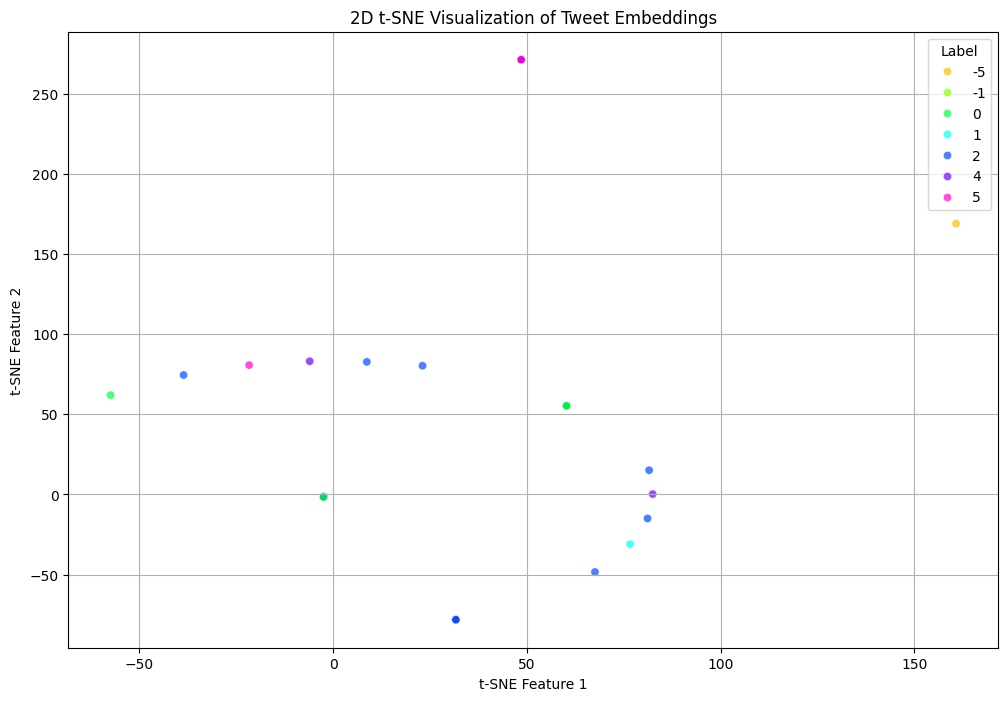

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)

# Create a DataFrame for visualization
df_viz_2d = pd.DataFrame({
    'x': train_embeddings_2d[:, 0],
    'y': train_embeddings_2d[:, 1],
    'label': train_labels
})

# Plot the 2D embeddings with improved details
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette=sns.color_palette('hsv', len(label_encoder.classes_)),
    data=df_viz_2d,
    legend='full',
    alpha=0.7
)
plt.title('2D t-SNE Visualization of Tweet Embeddings')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.show()


In [7]:
import pandas as pd
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load embeddings and labels
train_embeddings = torch.load('train_embeddings.pt').numpy()
train_labels = torch.load('train_labels.pt').numpy()

# Optional: Use t-SNE to reduce dimensions for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)


d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.

d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.

d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.

d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.

d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.

d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: 

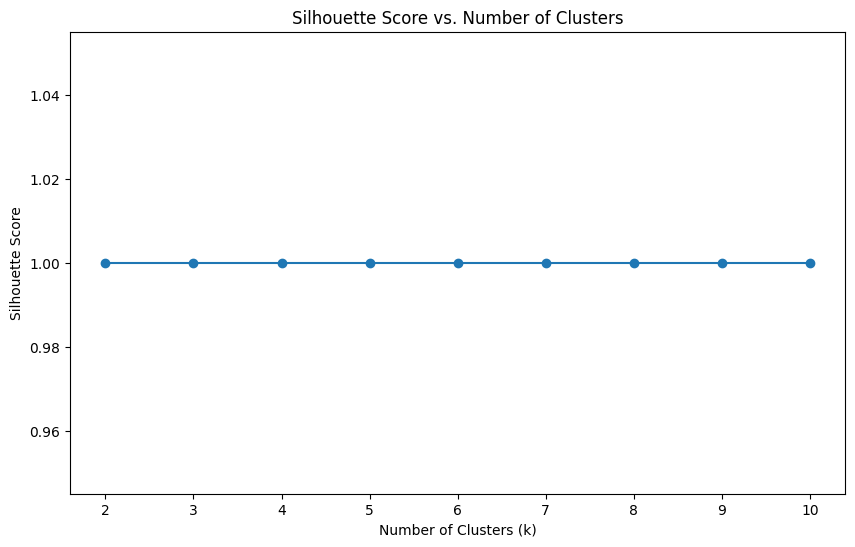

In [8]:
# Determine optimal number of clusters
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_embeddings)
    labels = kmeans.labels_
    sil_score = silhouette_score(train_embeddings, labels)
    sil_scores.append(sil_score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, sil_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.

C:\Users\Jeyanth\AppData\Local\Temp\ipykernel_24860\3497073709.py:17: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



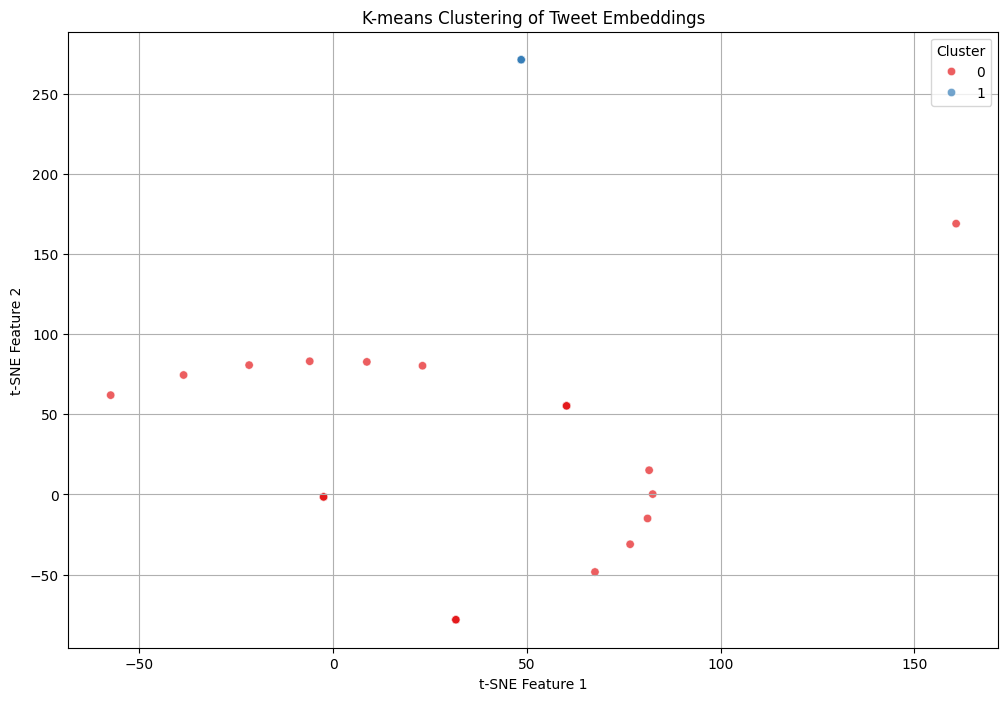

In [9]:
# Apply K-means clustering with optimal number of clusters
optimal_k = 4  # Replace with the actual optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(train_embeddings)
cluster_labels = kmeans.labels_

# Create a DataFrame for visualization
df_viz = pd.DataFrame({
    'x': train_embeddings_2d[:, 0],
    'y': train_embeddings_2d[:, 1],
    'cluster': cluster_labels,
    'label': train_labels
})

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette=sns.color_palette('Set1', optimal_k),
    data=df_viz,
    legend='full',
    alpha=0.7
)
plt.title('K-means Clustering of Tweet Embeddings')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


d:\SharedTask\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.

C:\Users\Jeyanth\AppData\Local\Temp\ipykernel_24860\3497073709.py:17: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



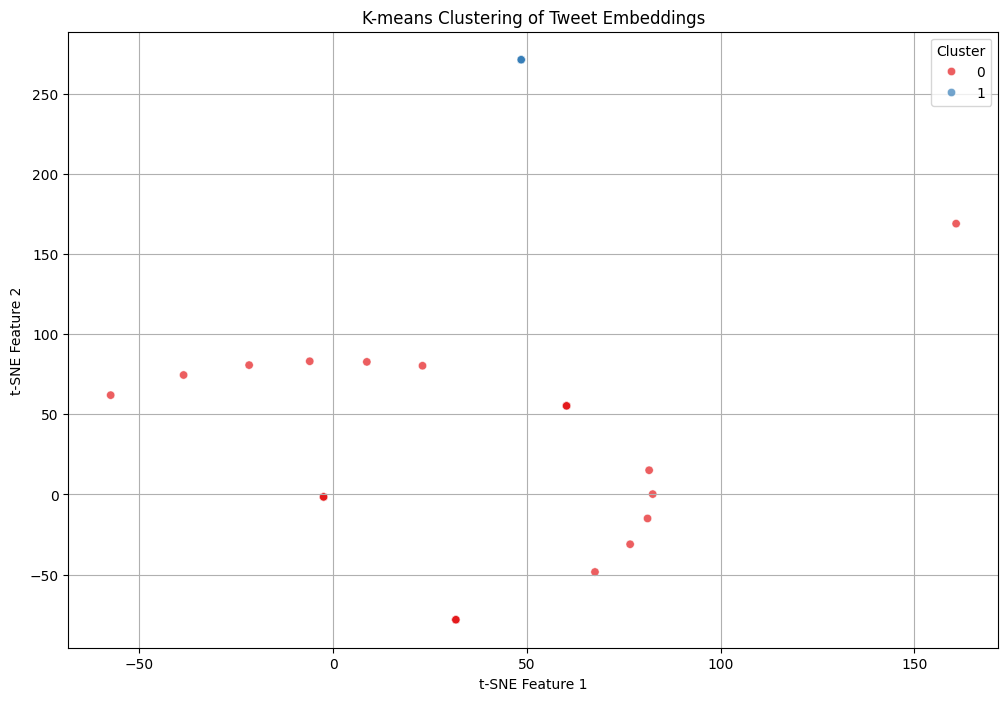

In [10]:
# Apply K-means clustering with optimal number of clusters
optimal_k = 4  # Replace with the actual optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(train_embeddings)
cluster_labels = kmeans.labels_

# Create a DataFrame for visualization
df_viz = pd.DataFrame({
    'x': train_embeddings_2d[:, 0],
    'y': train_embeddings_2d[:, 1],
    'cluster': cluster_labels,
    'label': train_labels
})

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette=sns.color_palette('Set1', optimal_k),
    data=df_viz,
    legend='full',
    alpha=0.7
)
plt.title('K-means Clustering of Tweet Embeddings')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


In [12]:
# Check for duplicates or anomalies in embeddings
import numpy as np
unique_embeddings = np.unique(train_embeddings, axis=0)
if len(unique_embeddings) != len(train_embeddings):
    print("There are duplicate or identical embeddings.")
else:
    print("No duplicates or identical embeddings.")


There are duplicate or identical embeddings.


C:\Users\Jeyanth\AppData\Local\Temp\ipykernel_24860\2780951934.py:16: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



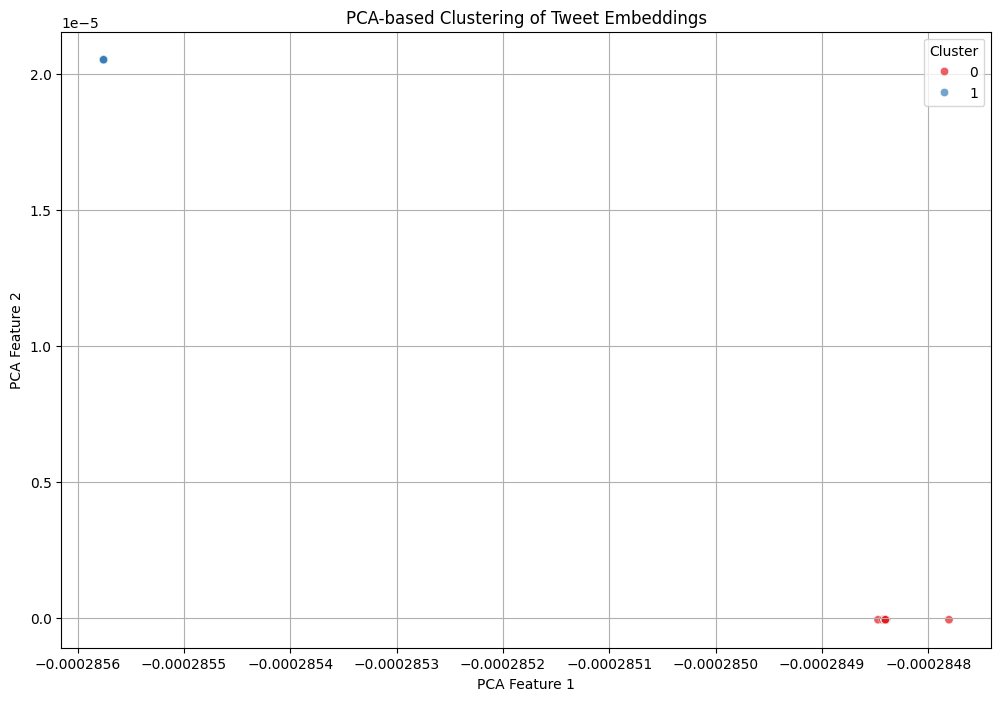

In [13]:
from sklearn.decomposition import PCA

# Using PCA instead of t-SNE
pca = PCA(n_components=2, random_state=42)
train_embeddings_pca = pca.fit_transform(train_embeddings)

# Plot PCA-based clustering
df_viz_pca = pd.DataFrame({
    'x': train_embeddings_pca[:, 0],
    'y': train_embeddings_pca[:, 1],
    'cluster': cluster_labels,
    'label': train_labels
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette=sns.color_palette('Set1', optimal_k),
    data=df_viz_pca,
    legend='full',
    alpha=0.7
)
plt.title('PCA-based Clustering of Tweet Embeddings')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


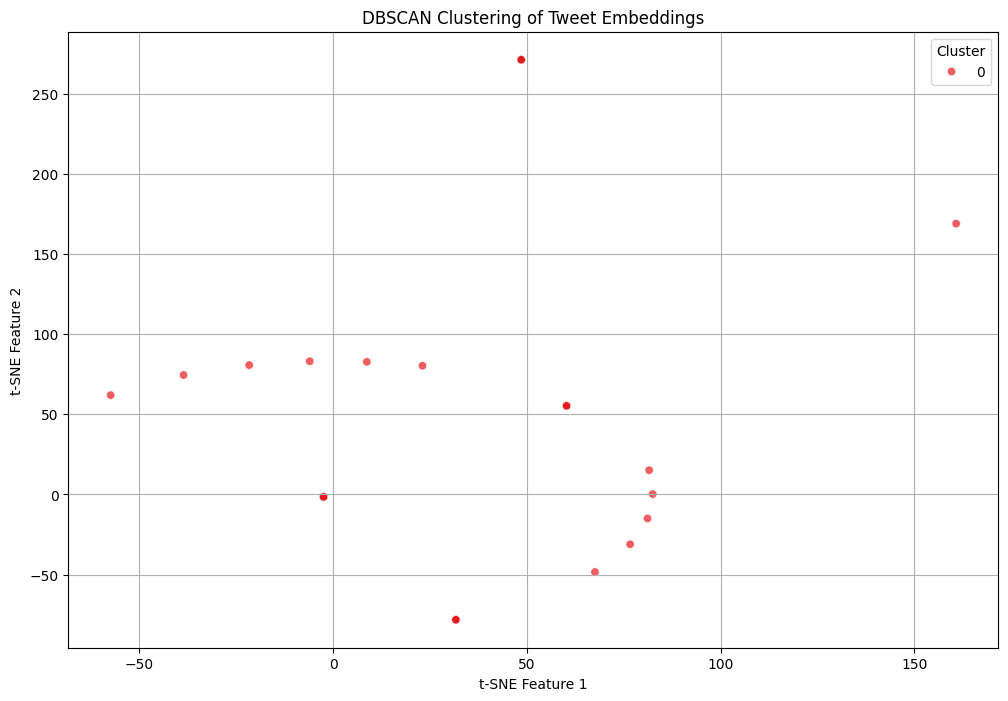

In [14]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(train_embeddings)
dbscan_labels = dbscan.labels_

# Visualize DBSCAN clusters
df_viz_dbscan = pd.DataFrame({
    'x': train_embeddings_2d[:, 0],
    'y': train_embeddings_2d[:, 1],
    'cluster': dbscan_labels,
    'label': train_labels
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette=sns.color_palette('Set1', len(set(dbscan_labels))),
    data=df_viz_dbscan,
    legend='full',
    alpha=0.7
)
plt.title('DBSCAN Clustering of Tweet Embeddings')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


In [15]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Load embeddings and labels
train_embeddings = torch.load('train_embeddings.pt').numpy()
train_labels = torch.load('train_labels.pt').numpy()


d:\SharedTask\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [25]:
# Find unique embeddings and their indices
unique_embeddings, unique_indices = np.unique(train_embeddings, axis=0, return_index=True)
unique_labels = train_labels[unique_indices]

print(f"Original dataset size: {train_embeddings.shape[0]}")
print(f"Unique dataset size: {unique_embeddings.shape[0]}")

# Ensure sufficient unique samples
if unique_embeddings.shape[0] < 2:
    raise ValueError("Not enough unique samples for clustering.")


Original dataset size: 3481
Unique dataset size: 2


In [26]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [27]:
class TamilTweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Ensure that all content is combined properly
def combine_features(row):
    sentence = row['sentence'] if 'sentence' in row else ''
    emojis = row['emojis'] if 'emojis' in row else ''
    tags = row['tags'] if 'tags' in row else ''
    return f"{sentence} {emojis} {tags}"

# Combine sentences with emojis and tags for tokenization
combined_texts = df.apply(combine_features, axis=1)

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    combined_texts, df['label'], test_size=0.2, random_state=42)

# Create data loaders
train_dataset = TamilTweetDataset(train_texts.tolist(), train_labels.tolist())
test_dataset = TamilTweetDataset(test_texts.tolist(), test_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


NameError: name 'df' is not defined